In [1]:
MODEL_NAME = "n_beats_3"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from multiprocessing.dummy import freeze_support
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['WANDB_NOTEBOOK_NAME'] = 'pytorch_stats_own_data.ipynb'
os.environ['WANDB_API_KEY'] = os.getenv('WANDB_API_KEY')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score, rmse

from darts import TimeSeries

from darts.datasets import EnergyDataset

import helper
import glob

from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(project="Digital-Energy")


AVAILABLE_GPUS = torch.cuda.device_count()
AVAILABLE_CPUS = os.cpu_count()

print(f"Available GPUs: {AVAILABLE_GPUS}")
print(f"Available CPUs: {AVAILABLE_CPUS}")


`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find pytorch_stats_own_data.ipynb.
wandb: Currently logged in as: timmermansjoy (use `wandb login --relogin` to force relogin)


Available GPUs: 2
Available CPUs: 32


In [9]:
my_time_series_dataset = []
for x in sorted(glob.glob("../../Data/london_clean/*.csv"))[:300]:
    df = pd.read_csv(f'{x}')
    df["DateTime"] = pd.to_datetime(df['DateTime'])
    df = df.groupby(pd.Grouper(key='DateTime', freq='1D')).max("KWHhh").round(3).reset_index()
    series = TimeSeries.from_dataframe(df, time_col='DateTime', value_cols='KWHhh')
    my_time_series_dataset.append(series)


In [11]:
## sets
training_sets = []
validation_sets = []
for x in my_time_series_dataset:
    train, val = series.split_after(0.85)
    training_sets.append(train)
    validation_sets.append(val)

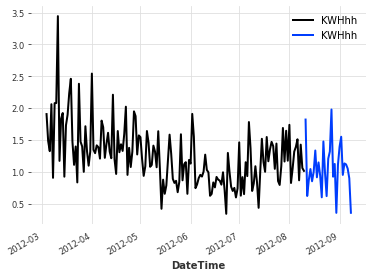

In [14]:
training_sets[200].plot()
validation_sets[200].plot()

In [19]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=15,
    num_blocks=1,
    num_layers=1,
    layer_widths=512,
    n_epochs=50,
    nr_epochs_val_period=1,
    batch_size=16,
    work_dir="../../Models",
    save_checkpoints=True,
    model_name=MODEL_NAME,
    pl_trainer_kwargs={
    "accelerator": "gpu",
    "devices": [1],
    "logger": wandb_logger,
    # "callbacks": [early_stop_callback]
    },
)

In [20]:
model_nbeats.fit(series=training_sets, val_series=validation_sets , verbose=True, num_loader_workers=AVAILABLE_CPUS)

[2022-05-02 14:04:58,303] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 37200 samples.
[2022-05-02 14:04:58,303] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 37200 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 37200 samples.


ValueError: __len__() should return >= 0

In [ ]:
for i in range(600,620):

    df = pd.read_csv(f'../../Data/london_clean/cleaned_household_MAC000{i}.csv')
    df["DateTime"] = pd.to_datetime(df['DateTime'])
    df = df.groupby(pd.Grouper(key='DateTime', freq='1D')).max("KWHhh").round(3).reset_index()
    series = TimeSeries.from_dataframe(df, value_cols=['KWHhh'], time_col="DateTime", fill_missing_dates=True)
    series = series[-150:]


    pred_series = model_nbeats.historical_forecasts(
        series,
        forecast_horizon=1,
        stride=1,
        retrain=False,
    )

    print(f"rmse: {rmse(series, pred_series)}.")
    print(f"R2 score: {r2_score(series, pred_series)}.")

    helper.display_forecast(pred_series, series, "1 day", save=True, fig_name=f"household_MAC000{i}", model_name=f"{MODEL_NAME}", fig_size=(20,10))


NameError: name 'pd' is not defined